
## 5G NR MIB and SIB1 Recovery

Before a mobile station (UE) can communicate with a 5G base station (gNodeB), it must first find the cell (cell ID), synchronize (time and frequency) with it, and read some basic information (MIB and SIB1).


To do this, it decodes two key messages:

-  MIB (Master Information Block) \- provides fundamental parameters required to access the network.
-  SIB1 (System Information Block Type 1) \- provides additional system configuration needed for the initial connection.

This implementation shows how a 5G receiver synchronizes and decodes these messages.

### A. Transmitter Side (Signal Generation)
-  The base station periodically transmits a Synchronization Signal Block (SSB).
-  Each SSB includes \- Primary Synchronization Signal (PSS), Secondary Synchronization Signal (SSS), and Physical Broadcast Channel (PBCH) which carries the MIB.
-  The SIB1 is carried on PDSCH (Physical Downlink Shared Channel).
### B. Wireless Channel (AWGN)
-  The signal is passed through a wireless channel with Additive White Gaussian Noise (AWGN).
-  Mathematically, the received signal is: r\[n\] = x\[n\] + w\[n\], where r\[n\] = received signal, x\[n\] = transmitted signal, w\[n\] = random noise with Gaussian distribution.
### C. Receiver Side

The receiver performs the following tasks:

-  Synchronization: Aligns timing and frequency using PSS and SSS.
-  Cell Identification: Determines the cell ID (NCellID) from detected PSS/SSS.
-  Demodulation: Demodulates PBCH to obtain the MIB.
-  Decoding: Uses the MIB information to decode PDCCH, PDSCH, and finally recover SIB1.

To synchronize and demodulate the received signal, receiver needs the following parameters to process the received waveform correctly:

| **Parameter** <br>  | **Meaning** <br>  | **Purpose** <br>   |
| :-- | :-- | :-- |
| Sample Rate <br>  | Number of samples per second <br>  | Used for OFDM demodulation and timing <br>   |
| Carrier Frequency (fPhaseComp) <br>  | RF center frequency of transmission <br>  | Used to correct phase rotation in received samples <br>   |
| MinChannelBW <br>  | Minimum allowed bandwidth (5, 10, or 40 MHz) <br>  | Helps determine CORESET 0 (control region) <br>   |
| SS Block Pattern <br>  | Defines SSB frequency and subcarrier spacing (Cases A\-E) <br>  | Helps decide search range and spacing <br>   |
| L\_max <br>  | Maximum number of SS/PBCH blocks (4, 8, or 64) in SS burst <br>  | Used for PBCH DMRS and descrambling <br>   |

### A. Generate Signal containing SS burst and SIB1

First, create an SS burst containing multiple SSBs at different symbol indices. Then generate SIB1, and finally generate the waveform containing both the SS burst and SIB1.

#### 1. SS Burst

An SS burst contains multiple SSB patterns (Case A \- Case G) depending on subcarrier spacing and carrier frequency range. It has a duration equal to half frame (5 subframe or 5 ms) and maximum number of SSBs per half frame depends on operating frequency band.

#### Generate SSB

An SSB occupies 240 subcarriers in frequency and 4 OFDM symbols in time. It is a self\-synchronization block containing PSS, SSS, PBCH, and PBCH\-DMRS, where the PBCH carries the MIB information. These components are transmitted in a specific pattern where PSS goes in first symbol SSB, SSS goes in 3rd symbol and PBCH along with DMRS goes in 2nd, 3rd, and 4th symbols.

#### Primary Synchronization Signal (PSS)

PSS is the first downlink used for radio synchronization. It helps UE to find out symbol boundary and helps UE to find out cell ID. It is generated using m\-sequence,  and occupies 127 subcarriers in frequency and 1 OFDM symbol in time.


$$\mathrm{CellID}=3\cdot N_{\mathrm{ID}\;}^1 +N_{\mathrm{ID}\;\;}^2 ,\mathrm{where}\;\mathrm{CellID}\in \left\lbrace 0,1,2,\cdots 1007\right\rbrace$$

$${N_{\textrm{ID}}^2 \in \left\lbrace 0,1,\cdots 335\right\rbrace \;\textrm{and}\;N}_{\textrm{ID}}^2 \in \left\lbrace 0,1,2\right\rbrace$$

To achieve time synchronization, the gNodeB transmits the PSS signal. The UE locally generates all three possible PSS sequences and correlates them with the received signal. When the correlation exceeds a predefined threshold, it indicates the correct symbol timing.

#### Generate m\-sequence

This is a binary sequence of length 127. It is produced using the relation:


$$x(i+7)=\bigl(x(i+4)+x(i)\bigr)\textrm{mod}2$$

Initial state: $[x(6)\;x(5)\;x(4)\;x(3)\;x(2)\;x(1)\;x(0)]=[1,1,1,0,1,1,0]$


(Here $x(0)$ is the LSB).


After the initial 7 bits, each new $x(i)$ is computed as:


$$x(i)=(x(i-3)+x(i-7))\textrm{mod}2$$
#### Compute $m(n)$

For each $n=0,1,\ldots,126$:


$$m(n)=(n+43\cdot N_{ID}^2 )\textrm{mod}127$$

where $N_{ID}^2 \in \lbrace 0,1,2\rbrace$

#### Map to $d_{\textrm{PSS}} (n)$

Finally computes:


$$d_{\textrm{PSS}} (n)=1-2\cdot x\bigl(m(n)\bigr)$$

This maps:


$$x(m(n))=0\;\;\to \;\;d_{\textrm{PSS}} (n)=+1\;\,$$

$$x(m(n))=1\;\;\to \;\;d_{\textrm{PSS}} (n)=-1\;$$

This is a BPSK\-mapped sequence that is transmitted as the PSS sequence in 5G NR as per TS 38.211 by 3GPP.



In [1]:
% generate a 240×4 matrix to represent the SS/PBCH block
ssb = zeros([240 4])

ssb = 240x4
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0


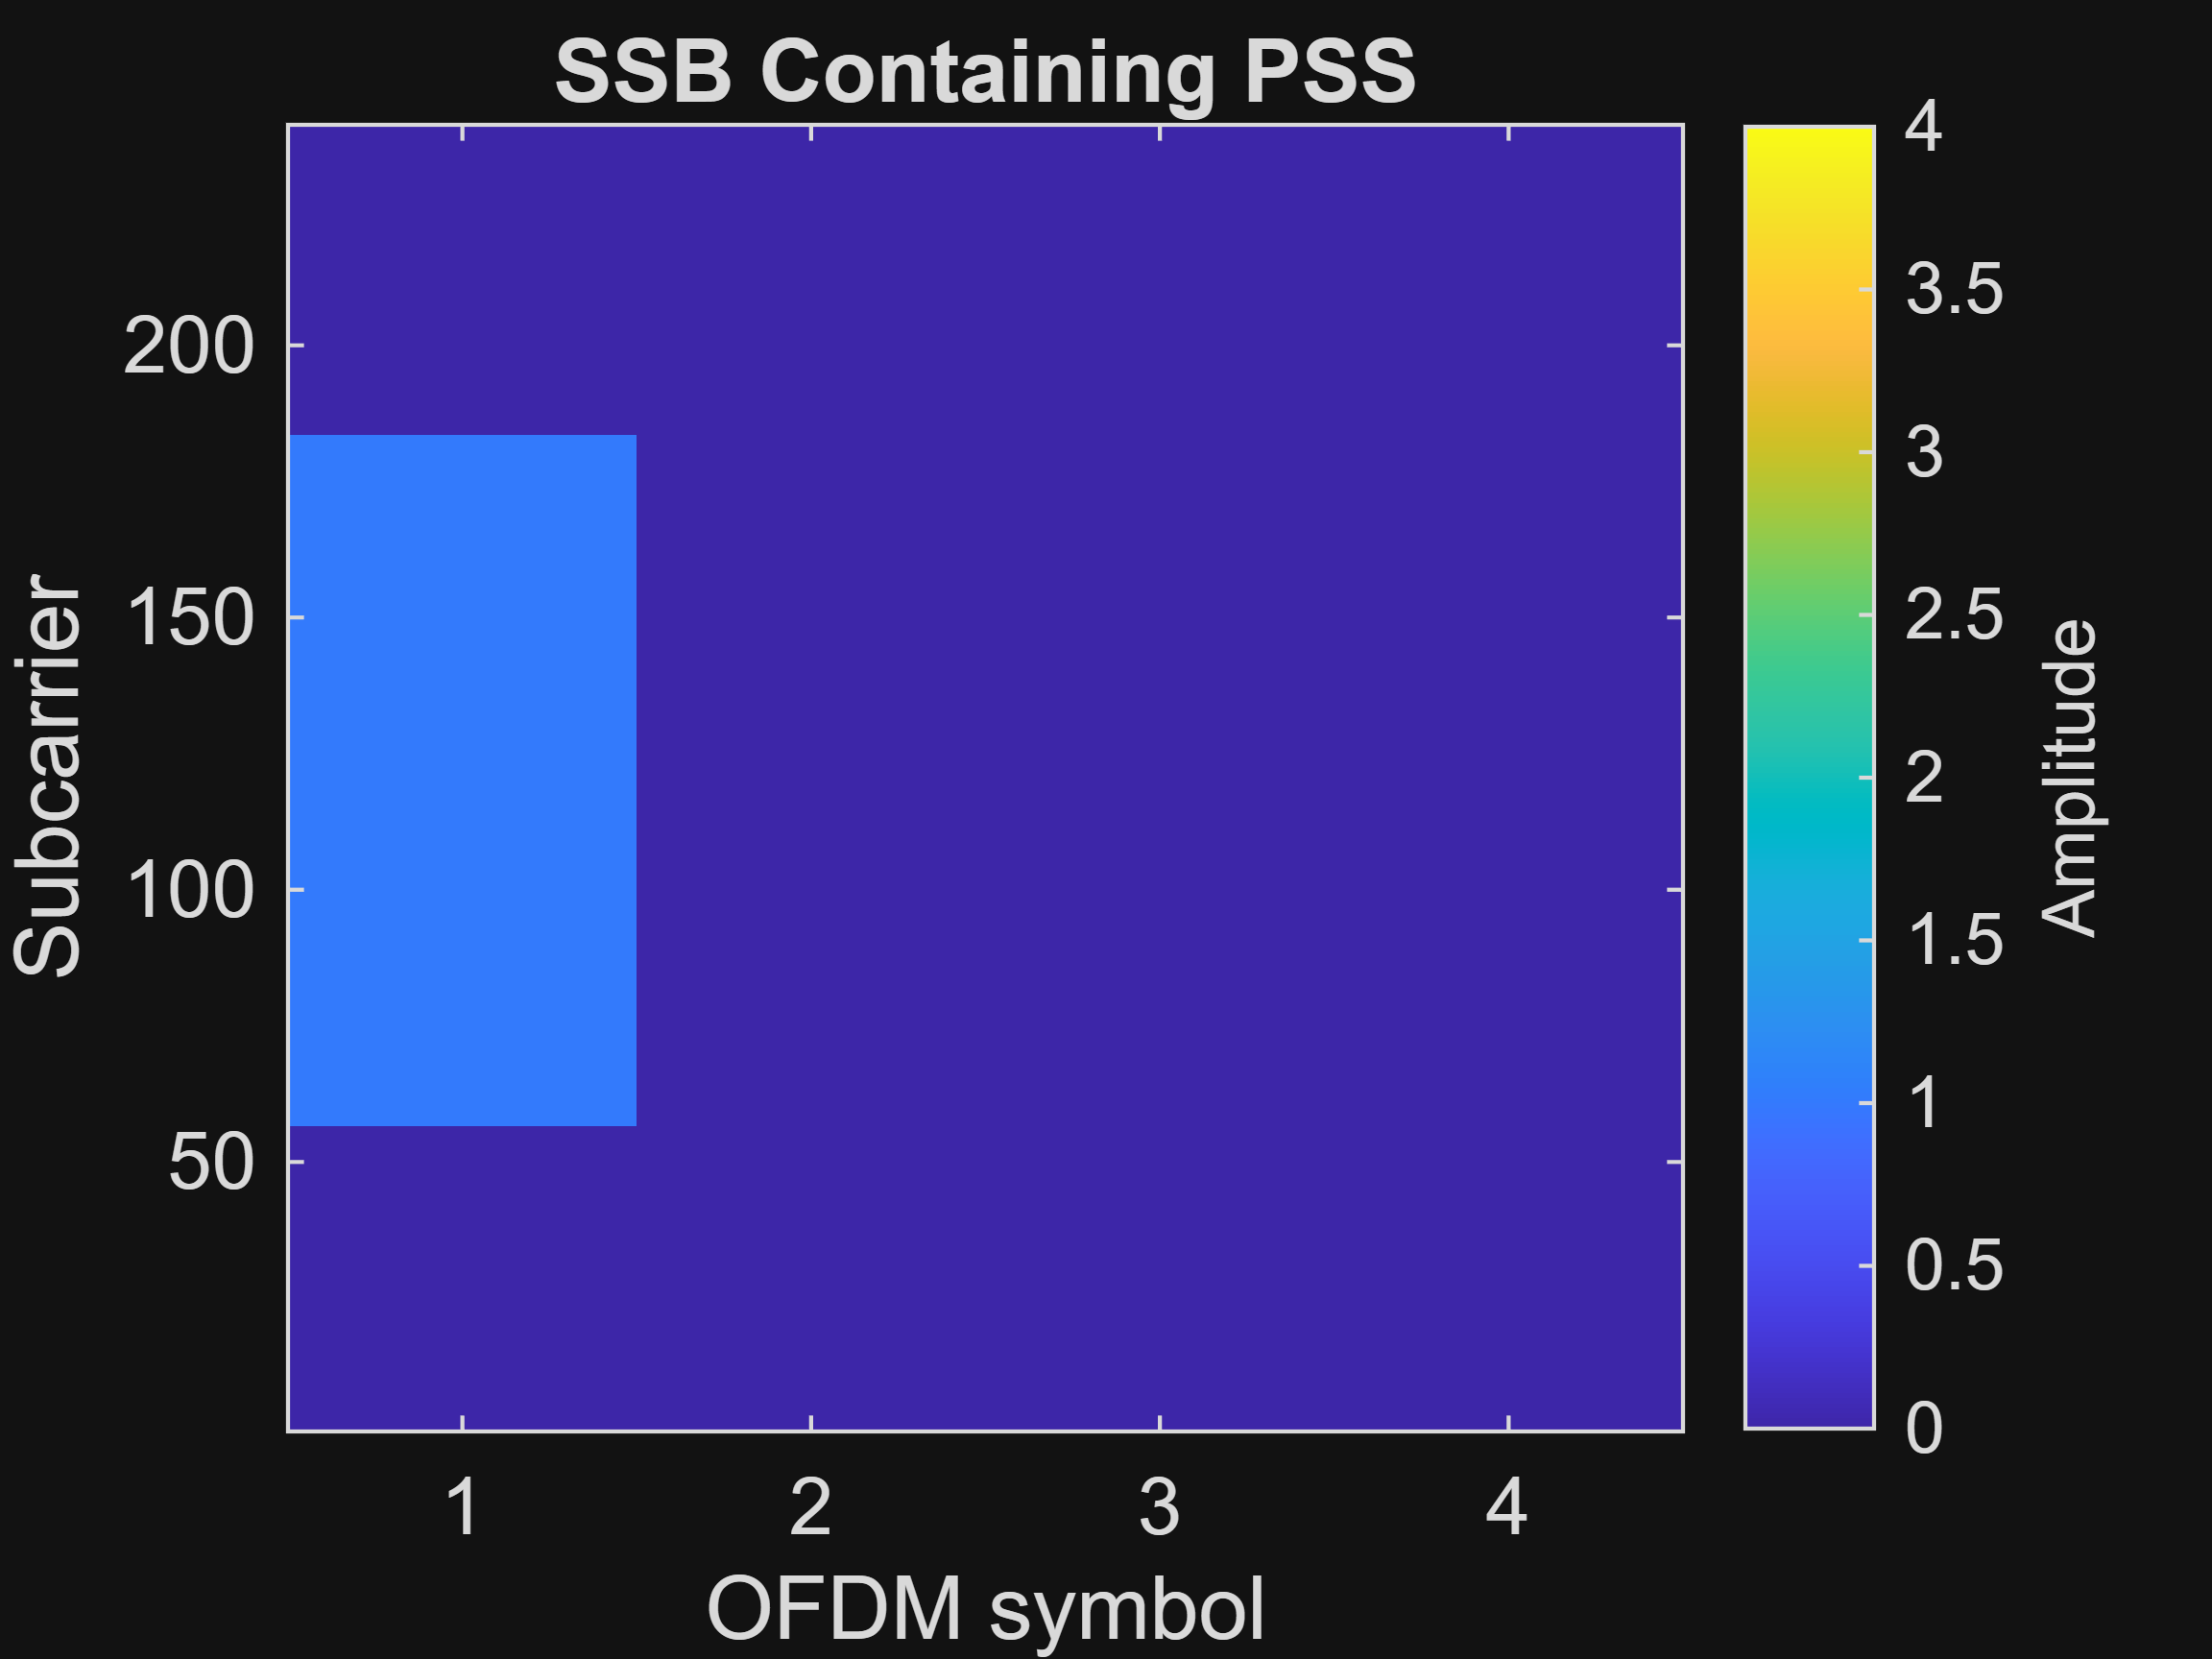

In [2]:

% generate PSS and PSS indices for a given cellID
cellID = 1;                 % Cell ID
pss = nrPSS(cellID);         % PSS sequence
pss_indices = nrPSSIndices; % PSS sequence indices

% map the PSS into SSB
ssb(pss_indices) = 1 * pss; % scale by beta=1 as per TS 38.211 Section 7.4.3.1.1

% plot the SSB containing PSS
imagesc(abs(ssb));
clim([0 4])
axis xy;
title('SSB Containing PSS');
ylabel('Subcarrier');
xlabel('OFDM symbol');

c = colorbar;
c.Label.String = 'Amplitude';

#### Secondary Synchronization Signal (SSS)

It is same as PSS, takes 127 subcarriers in frequency and 1 OFDM symbol in time. It is always transmitted as a part of SSB along with PSS. SSS along with PSS helps UE to find cell ID and do frame synchronization. It is generated using m\-sequence.

#### Compute $m_0$ and $m_1$

$$m_0 =15\cdot \left\lfloor \frac{N_{ID}^1 }{112}\right\rfloor +5\cdot N_{ID}^2$$

$$m_1 =N_{ID}^1 \textrm{mod}112$$

 $m_0$ and $m_1$ define the cyclic shifts for $x_0$ and $x_1$.

#### Generate m\-sequence $x_0 (i)$

$$x_0 (i+7)=\bigl(x_0 (i)+x_0 (i+4)\bigr)\textrm{mod}2$$

Initial state: $[x_0 (6)\;x_0 (5)\;x_0 (4)\;x_0 (3)\;x_0 (2)\;x_0 (1)\;x_0 (0)]=[0,0,0,0,0,0,1]$

#### Generate m\-sequence $x_1 (i)$

$$x_1 (i+7)=\bigl(x_1 (i+1)+x_1 (i)\bigr)\textrm{mod}2$$

same initial state as $x_0 (i)$.

#### Compute $m_0 (n)$ and $m_1 (n)$

For each $n=0,1,\ldots,126$:


$$m_0 (n)=(n+m_0 )\textrm{mod}127$$

$$m_1 (n)=(n+m_1 )\textrm{mod}127$$
#### Generate $d_{SSS} (n)$

$$dSSS(n)=\bigl(1-2\cdot x_0 (m_0 (n))\bigr)\cdot \bigl(1-2\cdot x_1 (m_1 (n))\bigr)$$

This performs BPSK mapping, where:


$$x₀(m₀(n)),x₁(m₁(n))=0\to \;\textrm{contributes}\;\textrm{+1}$$

$$x₀(m₀(n)),x₁(m₁(n))=1\to \;\textrm{contributes}\;\textrm{-}\textrm{1}$$


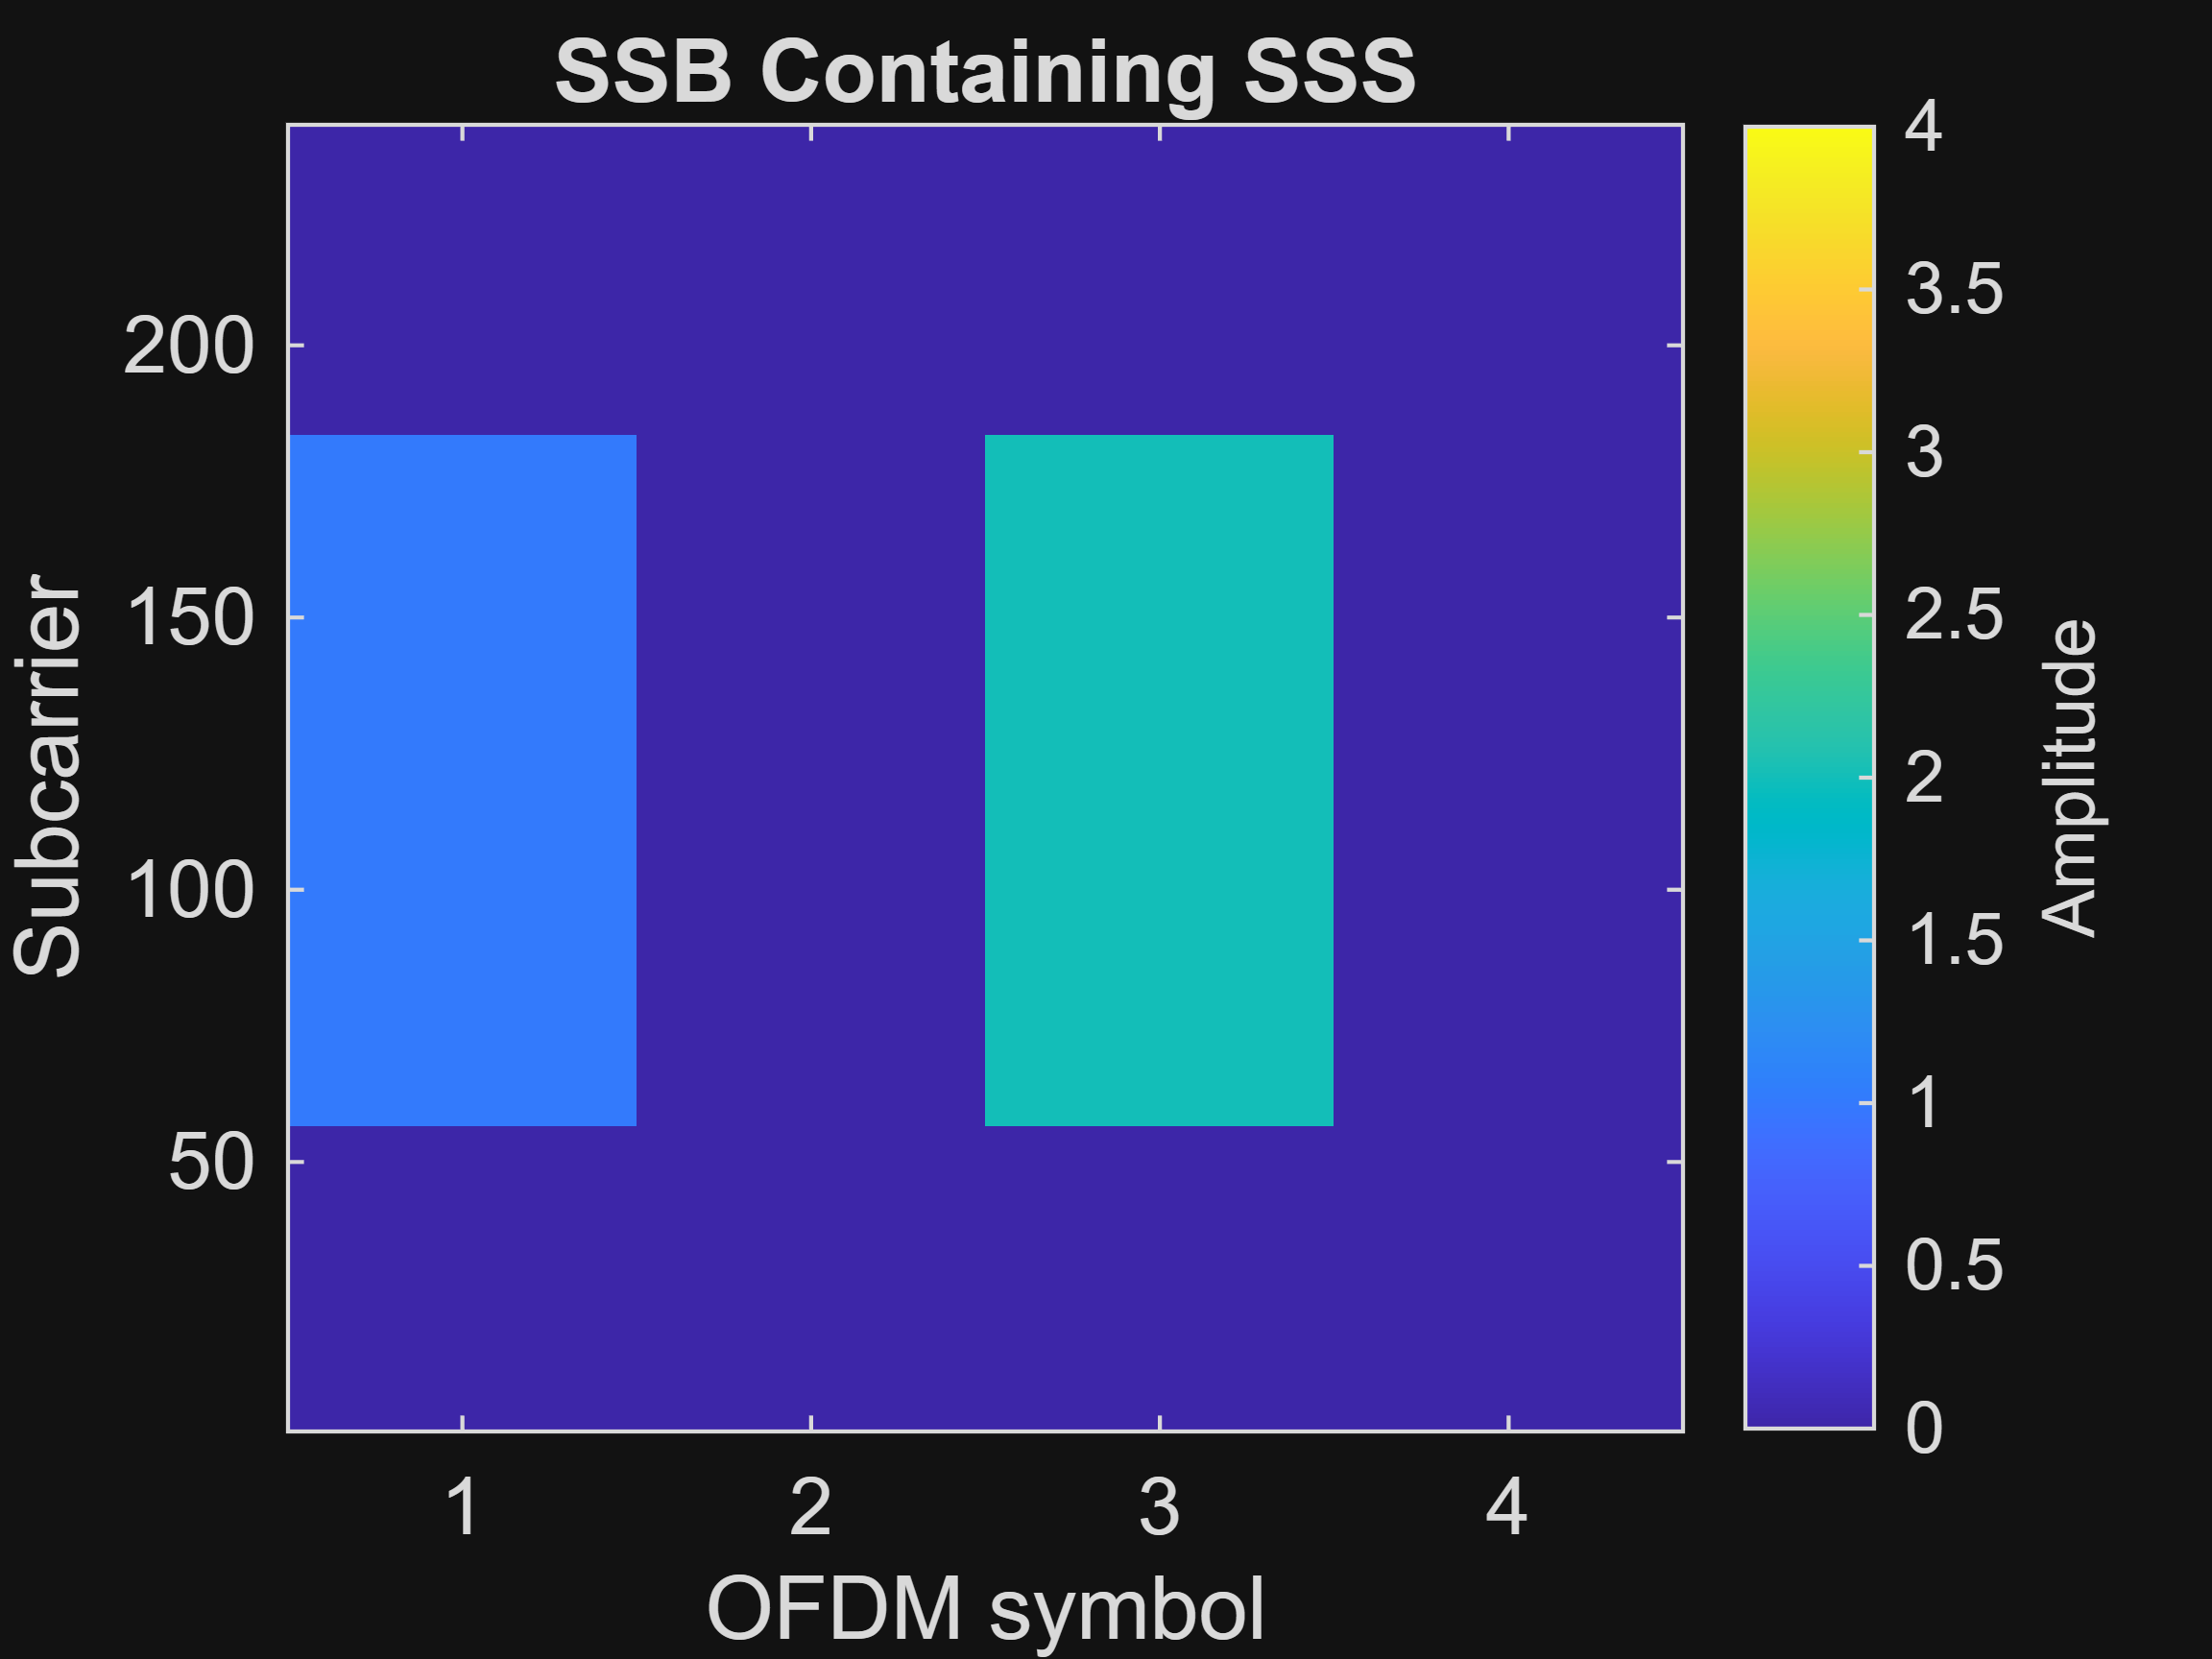

In [3]:
% generate the SSS and its indices and map it into SSB
sss = nrSSS(cellID);                 % SSS sequence
sss_indices = nrSSSIndices;         % SSS sequence indices
ssb(sss_indices) = 2 * sss;         % map the SSS, scaled by beta=2 as per TS 38.211 Section 7.4.3.1.1

% plot SSS
imagesc(abs(ssb));
clim([0 4])
axis xy;
title('SSB Containing PSS and SSS');
ylabel('Subcarrier');
xlabel('OFDM symbol');

c = colorbar;

In [4]:
c.Label.String = 'Amplitude';

#### Physical Broadcast Channel (PBCH)

PBCH carries the Master Information Block (MIB). In the 3GPP standard, the short MIB payload is CRC\-appended, then polar coded and rate\-matched into an 864\-bit codeword that is finally QPSK\-mapped and placed across the PBCH REs inside the SSB.


PBCH modulation consists of the following steps:

#### 1. Scrambling

Bits are scrambled according to:


$$\bar{b} (i)=\bigl(b(i)+c(i+vM_{\textrm{bit}} )\bigr)\textrm{mod}2$$

where:


 $b(i)$ is the input bit sequence.


 $c(i)$ is the scrambling sequence as defined in 3GPP TS 38.211.


 $M_{\textrm{bit}}$ is the number of bits transmitted on the physical broadcast channel.


 $v$ is 2 or 3 LSBs of SSB block index.

#### 2. Modulation

The scrambled bits $\bar{b} (i)$ are QPSK modulated as per 3GPP TS 38.211.

#### 3. Mapping

PBCH is mapped across time/frequency as follows:


OFDM symbol 1 → subcarriers $k=0\ldots239$


OFDM symbol 3 → subcarriers $k=0\ldots239$


OFDM symbol 2 → edge ranges $k=0\ldots47$ and $k=192\ldots239\,$



In [5]:
% consider a codeword and take v = 0

codeword = randi([0, 1], 864, 1);     % take random some random bits
v = 0

v = 0


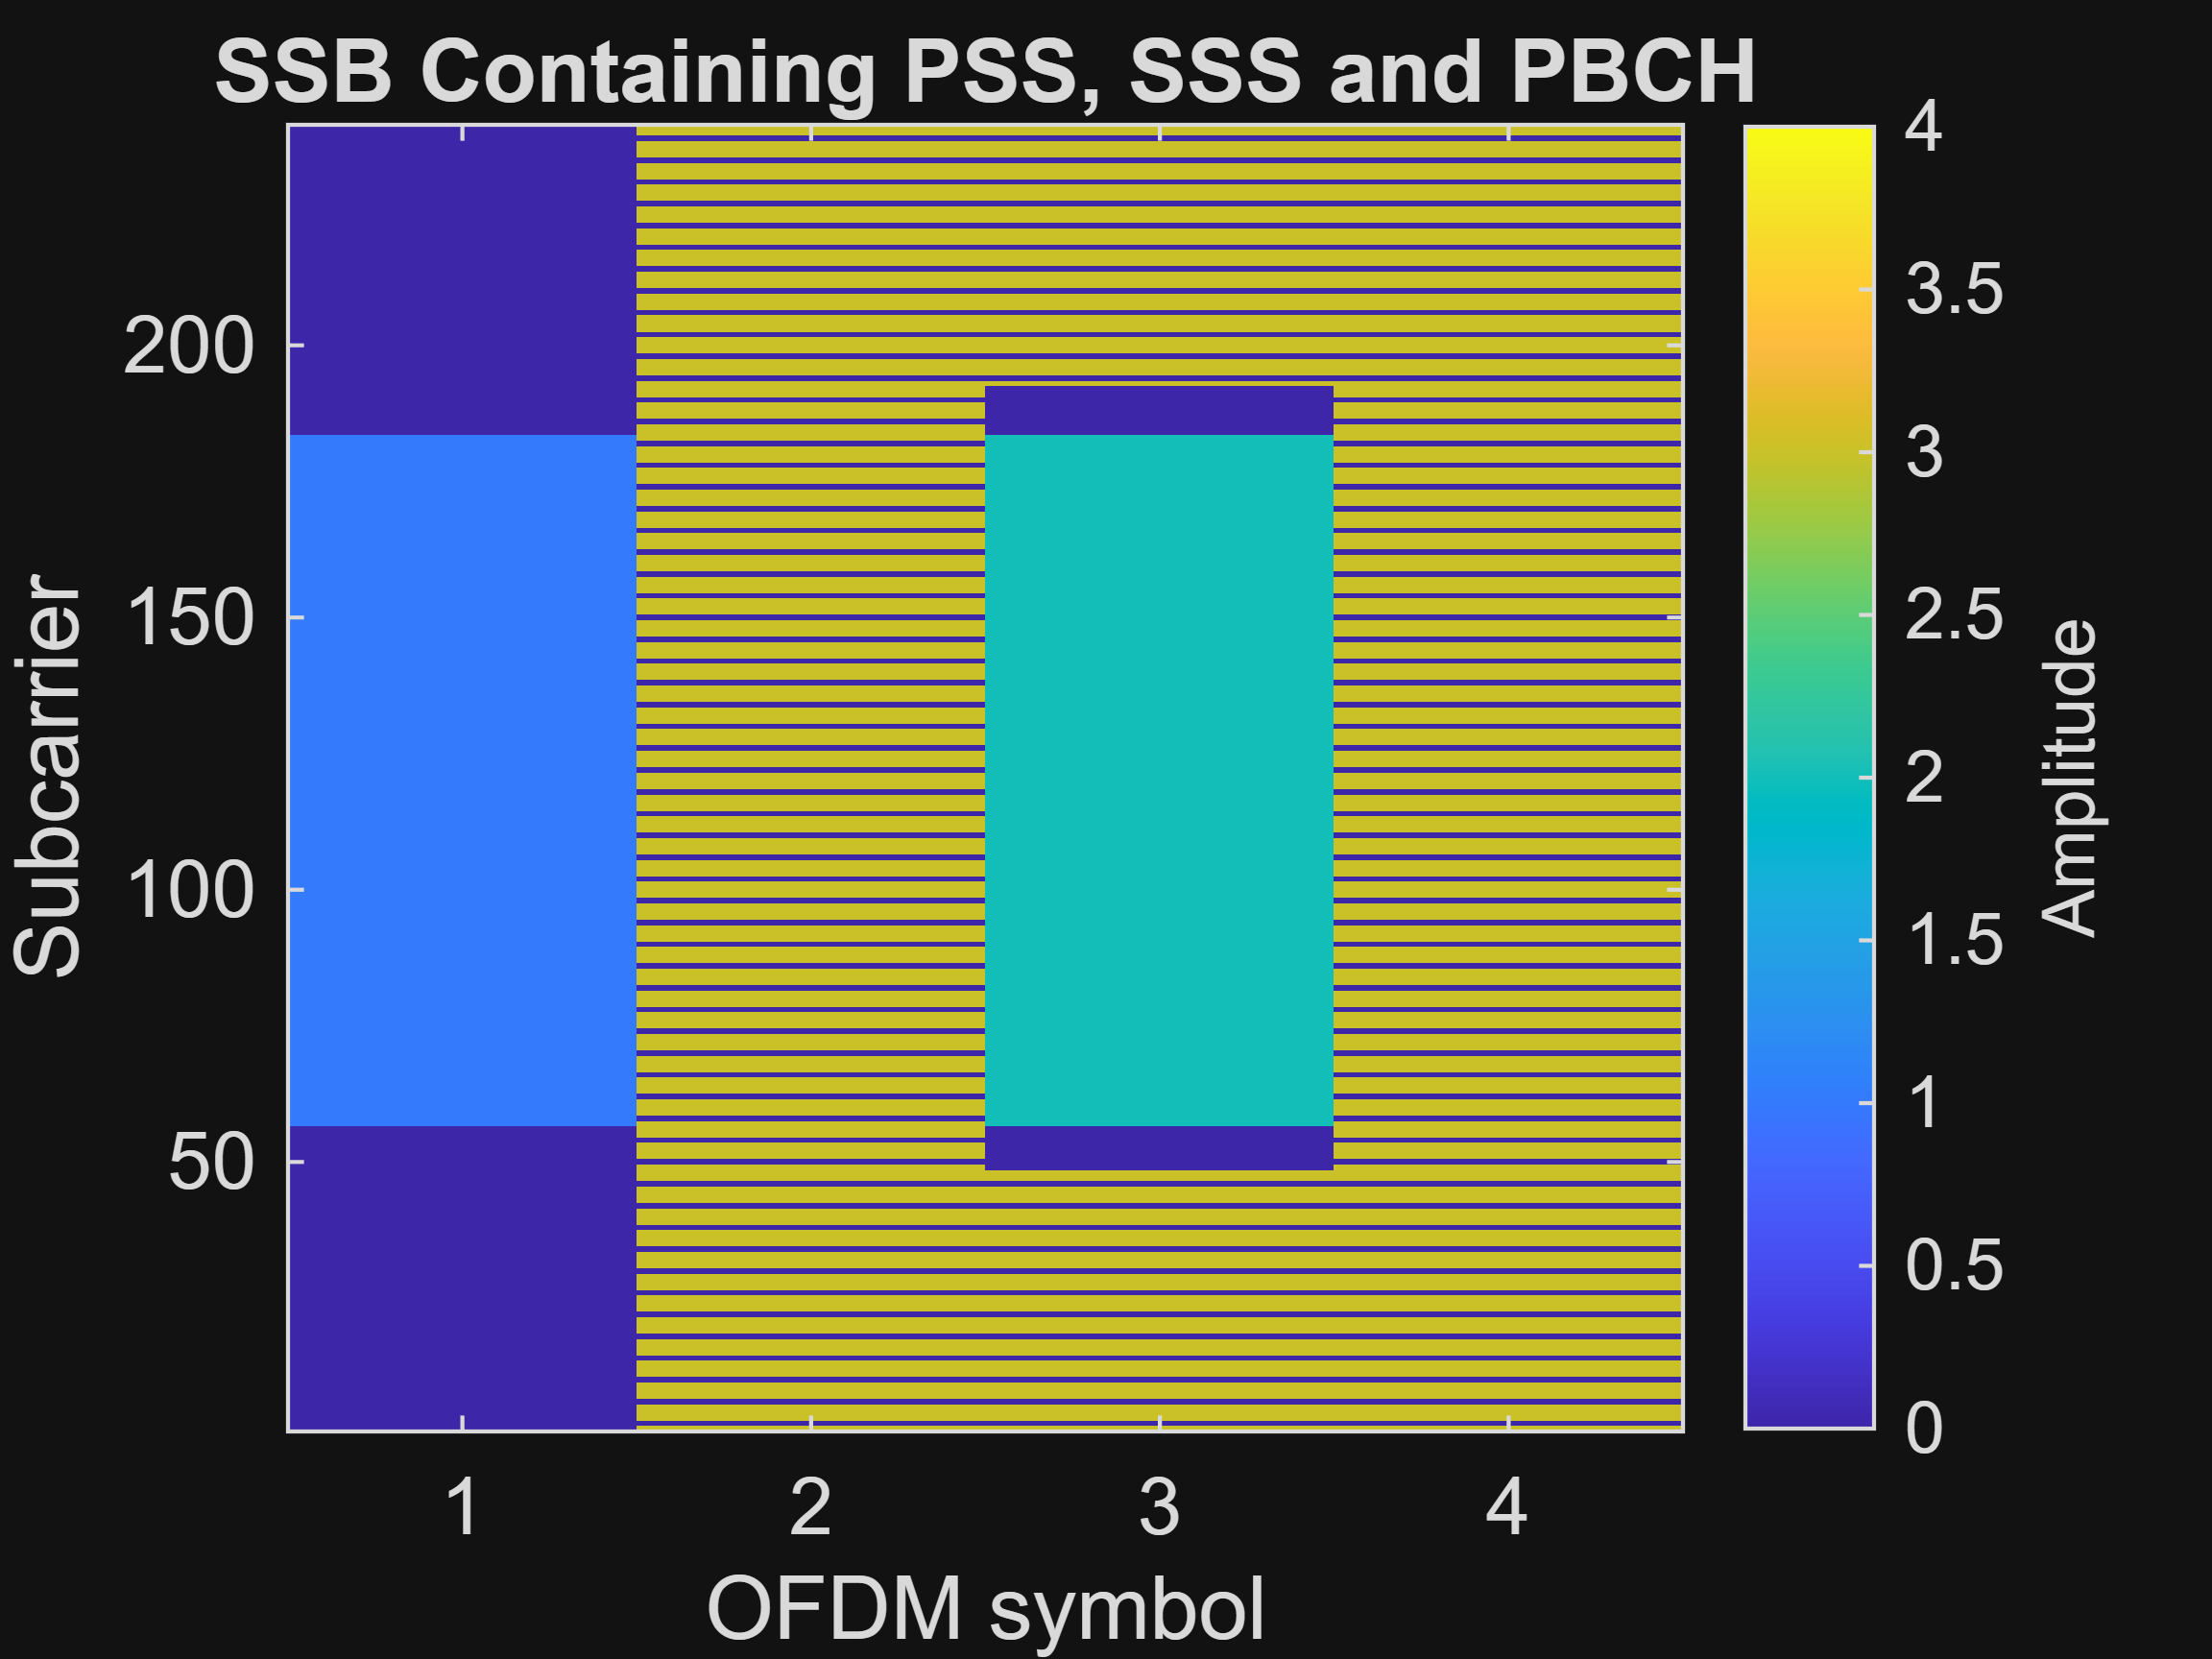

In [6]:
pbch = nrPBCH(codeword, cellID, v);   % PBCH sequence
pbch_indices = nrPBCHIndices(cellID); % PBCH indices
ssb(pbch_indices) = 3 * pbch;         % map the PBCH, scaled by beta=3 as per TS 38.211 Section 7.4.3.1.1

% plot the PBCH into SSB
imagesc(abs(ssb));
clim([0 4])
axis xy;
title('SSB Containing PSS, SSS and PBCH');
ylabel('Subcarrier');
xlabel('OFDM symbol');

c = colorbar;
c.Label.String = 'Amplitude';

#### **PBCH Demodulation Reference Signal (PBCH DM\-RS)**

DMRS is a 144\-symbol sequence (per SSB) that depends on the Cell ID and the time index part ${\bar{i} }_{SSB}$ (SSB index).


The UE shall assume the reference\-signal sequence $r(m)$ for an SSB is defined by


$$r(m)=\frac{1}{\sqrt{2}}\Bigl\lbrack \bigl(1-2\cdot c(2m)\bigr)+j\cdot \bigl(1-2\cdot c(2m+1)\bigr)\Bigr\rbrack$$

where $c(n)$ is the scrambling sequence.




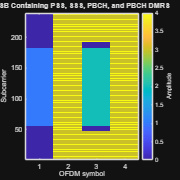

In [7]:
% consider ibar_ssb = 0

ibar_ssb = 0;                                  % initialize ibar_ssb
pbch_dmrs = nrPBCHDMRS(cellID, ibar_ssb);      % generate DMRS
pbch_dmrs_indices = nrPBCHDMRSIndices(cellID); % get DMRS indices for PBCH
ssb(pbch_dmrs_indices) = 4 * pbch_dmrs;        % map the PBCH DMRS into SSB, scaled by beta=4

% plot PBCH DMRS into SSB
imagesc(abs(ssb));
clim([0 4])
axis xy;
title('SSB Containing PSS, SSS, PBCH, and PBCH DMRS');
ylabel('Subcarrier');
xlabel('OFDM symbol');

c = colorbar;
c.Label.String = 'Amplitude';

In [8]:



% code here